In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
#Reading dataset
df=pd.read_csv('Hybrid_ESP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_name          68 non-null     object 
 1   Cate_HOMO          68 non-null     float64
 2   Cate_LUMO          68 non-null     float64
 3   Cate_ESP_O1        68 non-null     float64
 4   Cate_ESP_H1        68 non-null     float64
 5   Cate_ESP_O2        68 non-null     float64
 6   Cate_ESP_H2        68 non-null     float64
 7   Cate_BL_ArO1       68 non-null     float64
 8   Cate_BL_O1H1       68 non-null     float64
 9   Cate_BL_ArO2       68 non-null     float64
 10  Cate_BL_O2H2       68 non-null     float64
 11  Cate_total_dipole  68 non-null     float64
 12  P_name             68 non-null     object 
 13  P_HOMO             68 non-null     float64
 14  P_LUMO             68 non-null     float64
 15  P_ESP_P            68 non-null     float64
 16  P_ESP_=O           68 non-nu

In [3]:
#Building descriptors
X = df.drop(columns=['Yield', 'Cate_name', 'P_name' ])
print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_HOMO  Cate_LUMO  Cate_ESP_O1  Cate_ESP_H1  Cate_ESP_O2  Cate_ESP_H2  \
0      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
1      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
2      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
3      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
4      -5.51       0.22    -0.542028     0.433177    -0.582447     0.440296   

   Cate_BL_ArO1  Cate_BL_O1H1  Cate_BL_ArO2  Cate_BL_O2H2  ...  rdkit_catePC1  \
0         1.363         0.969         1.378         0.965  ...      -5.580019   
1         1.363         0.969         1.378         0.965  ...      -5.580019   
2         1.363         0.969         1.378         0.965  ...      -5.580019   
3         1.363         0.969         1.378         0.965  ...      -5.580019   
4         1.364         0.969         1.379         0.965  ...      -2.835492   

   rdkit_catePC2  rd

In [4]:
seed=3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
#autoscaling
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_y_train = y_train/10

param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
           'learning_rate_init':[0.003,0.03]}
    
reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=8)
reg_mlp.fit(a_X_train,a_y_train['Yield'])
reg_best = reg_mlp.best_estimator_
y_pred1 = reg_best.predict(a_X_train)*10
y_pred2 = reg_best.predict(a_X_test)*10
            
#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
print('R2_train:', r2_train)
print('R2_test:', r2_test)

R2_train: 0.9766606769071275
R2_test: 0.89981781398729


In [5]:
explainer = shap.KernelExplainer(reg_best.predict, a_X_train)
shap_values = explainer(a_X_train)
y_train

100%|███████████████████████████████████████████| 47/47 [00:29<00:00,  1.61it/s]


,Yield
18,3
9,7
36,54
64,44
51,96
23,63
53,7
48,59
55,72
46,3


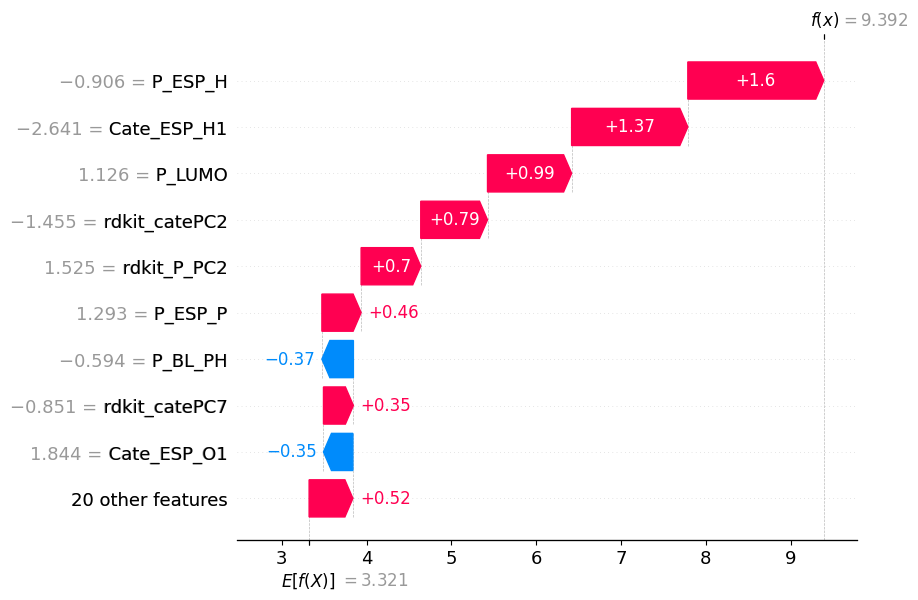

In [6]:
entry = 46 #4a+5g
fig = plt.figure()
shap.plots.waterfall(shap_values[entry], show=False, max_display=10)
plt.show()
fig.savefig('waterfall_4a+5g.pdf')

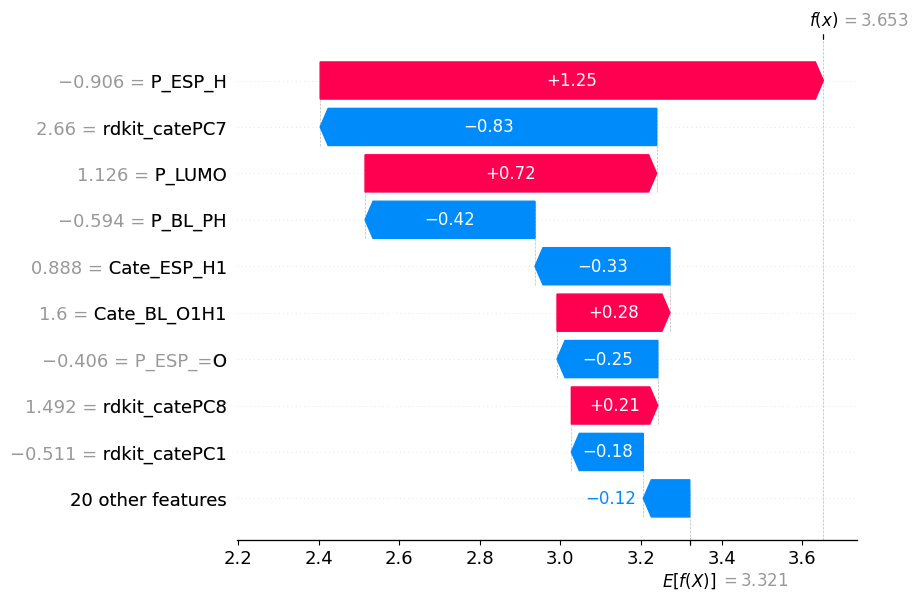

In [7]:
entry = 31 #4a+5f
fig = plt.figure()
shap.plots.waterfall(shap_values[entry], show=False, max_display=10)
plt.show()
fig.savefig('waterfall_4a+5f.pdf')

In [8]:
explainer = shap.KernelExplainer(reg_best.predict, a_X_test)
shap_values = explainer(a_X_test)
y_test

100%|███████████████████████████████████████████| 21/21 [00:06<00:00,  3.29it/s]


,Yield
13,7
65,5
42,4
25,16
11,64
6,3
40,78
8,47
66,3
4,99


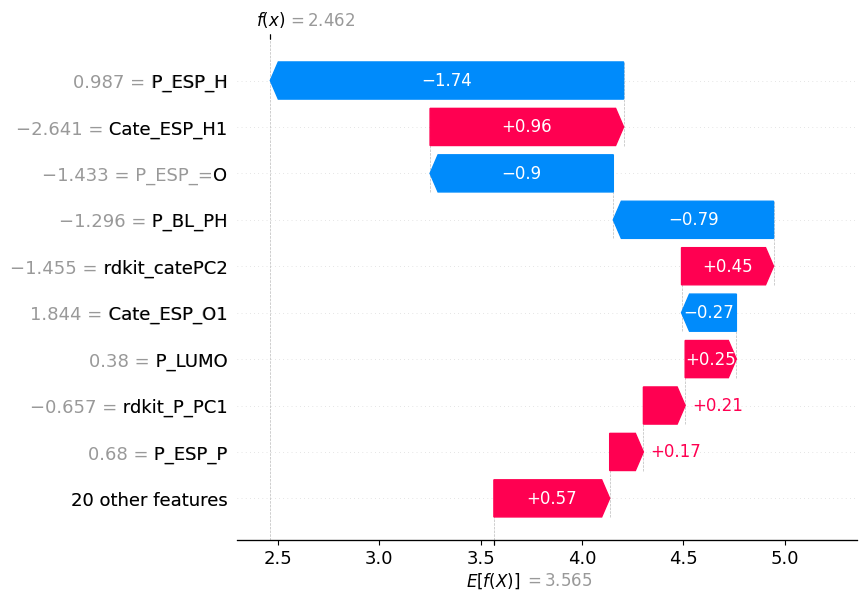

In [9]:
entry = 3 #4b+5g
fig = plt.figure()
shap.plots.waterfall(shap_values[entry], show=True, max_display=10)
plt.show()
fig.savefig('waterfall_4b+5g.pdf')

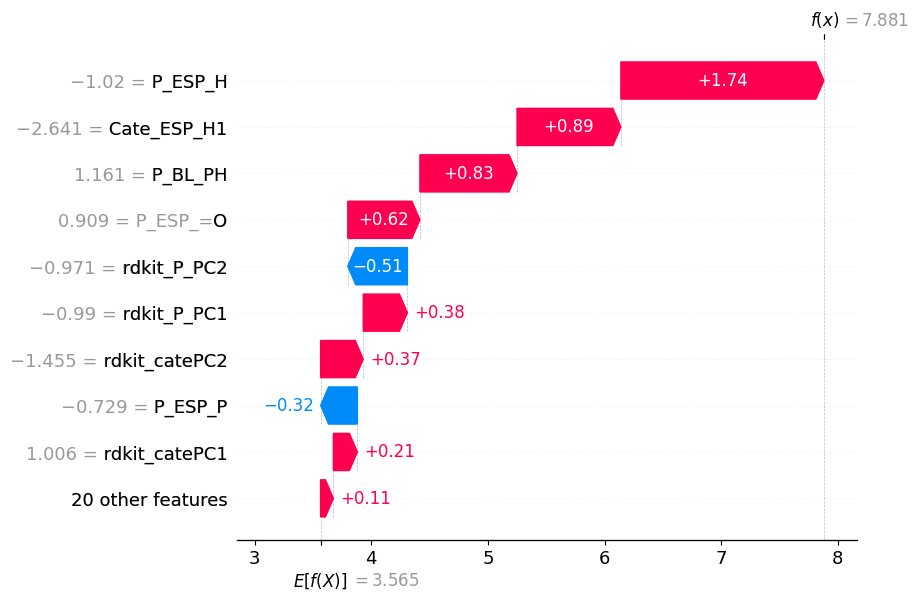

In [10]:
entry = 20 #4d+5g
fig = plt.figure()
shap.plots.waterfall(shap_values[entry], show=False, max_display=10)
plt.show()
fig.savefig('waterfall_4d+5g.pdf')

In [ ]:
# Output files were deleted in Github.